In [ ]:
# Playing with rotation matricies

import numpy as np
import math

lat = 0
long = 0
twist = 270
lat = math.radians(lat)
long = math.radians(long)
twist = math.radians(twist)

print(twist)
print(math.cos(twist))
print(math.sin(twist))


Rx = np.array([[1,0,0],
               [0,np.cos(twist),-np.sin(twist)],
               [0,np.sin(twist),np.cos(twist)]])
Ry = np.array([[np.cos(lat),0,np.sin(lat)],
               [0,1,0],
               [-np.sin(lat),0,np.cos(lat)]])
Rz = np.array([[np.cos(twist),-np.sin(twist),0],
               [np.sin(twist),np.cos(twist),0],
               [0,0,1]])
Rz2 = np.array([[np.cos(long),-np.sin(long),0],
               [np.sin(long),np.cos(long),0],
               [0,0,1]])

print(Rx)

R = Rx
#R = np.matmul(Rz2,Ry,Rx)
#R = np.matmul(Rz2,Ry,Rz)
R = R.flatten()
R[np.abs(R) < 0.0001] = 0


for i in range(1, len(R) + 1):
    print(R[i-1], end=' ')
    if i % 3 == 0:
        print(0, end=' ')
for i in range(3):
    print(0, end=' ')
print(1)

In [ ]:
# Patrick script

# Input: Takes in the GML file 
# Output: A Dictionary indexed by Building Identification with attributes
#         X (min, max), Y (min, max), Z (min, max), BIN, DOITT_ID, SOURCE_ID
def parse(GML_file):
    fp = open(GML_file)
    buildings = dict()
    current = None
    for line in fp:
        if "bldg:Building" in line:
            raw_name = fp.readline()
            bldg_id = raw_name.split('>')[1].split('<')[0]
            buildings[bldg_id] = dict()
            buildings[bldg_id]["X"] = [float("inf"),-float("inf")]
            buildings[bldg_id]["Y"] = [float("inf"),-float("inf")]
            buildings[bldg_id]["Z"] = [float("inf"),-float("inf")]
            current = bldg_id
        if "/bldg:Building" in line:
            current = None
        if "BIN" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['BIN'] = bld_id
        if "DOITT_ID" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['DOITT_ID'] = bld_id
        if "SOURCE_ID" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['SOURCE_ID'] = bld_id
        if "<gml:posList>" in line and "</gml:posList>" in line:
            points = line.split('>')[1].split('<')[0]
            points = points.split(' ')
            for p in range(len(points)//3):
                x = float(points[3*p])
                y = float(points[3*p+1])
                z = float(points[3*p+2])
                if x > buildings[bldg_id]["X"][1]:
                    buildings[bldg_id]["X"][1] = x
                if x < buildings[bldg_id]["X"][0]:
                    buildings[bldg_id]["X"][0] = x
                if y > buildings[bldg_id]["Y"][1]:
                    buildings[bldg_id]["Y"][1] = y
                if y < buildings[bldg_id]["Y"][0]:
                    buildings[bldg_id]["Y"][0] = y
                if z > buildings[bldg_id]["Z"][1]:
                    buildings[bldg_id]["Z"][1] = z
                if z < buildings[bldg_id]["Z"][0]:
                    buildings[bldg_id]["Z"][0] = z
    return buildings

In [1]:
# Adjusted Patrick script

# Input: Takes in the GML file 
# Output: A dictionary with key = Building Identification (e.g. Bldg_12210009096) 
#         and value = [(X1, Y1, Z1), (X2, Y2, Z2), etc.]
def parseAllCoordinates(GML_file):
    fp = open(GML_file)
    buildings = dict()
    current = None
    for line in fp:
        if "bldg:Building" in line:
            raw_name = fp.readline()
            bldg_id = raw_name.split('>')[1].split('<')[0]
            buildings[bldg_id] = dict()
            buildings[bldg_id] = []
            current = bldg_id
        if "<gml:posList>" in line and "</gml:posList>" in line:
            points = line.split('>')[1].split('<')[0]
            points = points.split(' ')
            for p in range(len(points)//3):
                x = float(points[3*p])
                y = float(points[3*p+1])
                z = float(points[3*p+2])
                buildings[current].append((x,y,z))
        if "/bldg:Building" in line:
            current = None
                
    return buildings

In [2]:
GML_file = '/Users/mogryzko/Desktop/NYC buildings 3D/DA_WISE_GMLs/test/DA12_3D_Buildings_Merged.gml'

building_pts = parseAllCoordinates(GML_file)

In [39]:
def extract(s):
    pixel_size = s[s.find('PixelSizeMm') + 13:]
    pixel_size = float(pixel_size[:pixel_size.find(' ')])
    #edit
    pixel_size = 0.00122
    focal_length = s[s.find('FocalMm') + 9:]
    focal_length = float(focal_length[:focal_length.find('"')])
    #edit
    focal_length = 25
    fx = focal_length/pixel_size
    fy = focal_length/pixel_size
    intrinsic_matrix = np.array([[fx,0,0],
                            [0,fy,0],
                            [0,0,1]])
    rotation_matrix = s[s.find('RotationMatrix') + 16:]
    rm = [float(i) for i in rotation_matrix[:rotation_matrix.find('"')].split(' ')[:-1]]
    R = np.array([rm[:3],rm[4:7],rm[8:11]])
    #edit
    #R = np.linalg.inv(R)
    print(R)
    translation_vector = s[s.find('TranslationVector') + 19:]
    T = np.array([[float(i)] for i in translation_vector[:translation_vector.find('"')].split(' ')[:-1]])
    print(T)
    extrinsic_matrix = np.append(R,T,axis=1)

    camera_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)
    return camera_matrix

In [43]:
x=89
y=103
z=-114

SyntaxError: can't assign to literal (<ipython-input-43-a380bdfa6017>, line 1)

[[-0.634289  -0.770917   0.0580057]
 [ 0.13576   -0.0372063  0.990043 ]
 [-0.761083   0.635848   0.128259 ]]
[[-9.86157e+05]
 [-2.12962e+05]
 [-6.21725e+02]]


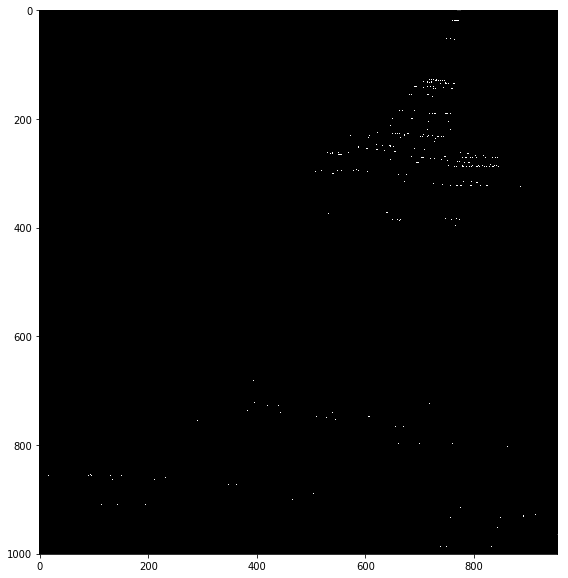

'\nrx = 0\nry = 0\nrz = 0\n\ntx = 0\nty = 0\ntz = 0\n\n\nrx = math.radians(rx)\nry = math.radians(ry)\nrz = math.radians(rz)\n\nRx = np.array([[1,0,0],\n               [0,np.cos(twist),-np.sin(twist)],\n               [0,np.sin(twist),np.cos(twist)]])\nRy = np.array([[np.cos(lat),0,np.sin(lat)],\n               [0,1,0],\n               [-np.sin(lat),0,np.cos(lat)]])\nRz = np.array([[np.cos(twist),-np.sin(twist),0],\n               [np.sin(twist),np.cos(twist),0],\n               [0,0,1]])\nRz2 = np.array([[np.cos(long),-np.sin(long),0],\n               [np.sin(long),np.cos(long),0],\n               [0,0,1]])\n\n\nR = np.matmul(Rz2,Ry,Rz)\nR[np.abs(R) < 0.0001] = 0\n'

In [41]:
# TESTING 

import numpy as np
import matplotlib.pyplot as plt

s = '''<!DOCTYPE ViewState>
<project>
 <VCGCamera CameraType="0" PixelSizeMm="0.0369161 0.0369161" FocalMm="19.8855" TranslationVector="-986157 -212962 -621.725 1" RotationMatrix="-0.634289 -0.770917 0.0580057 0 0.13576 -0.0372063 0.990043 0 -0.761083 0.635848 0.128259 0 0 0 0 1 " LensDistortion="0 0" ViewportPx="907 622" CenterPx="453 311"/>
 <ViewSettings FarPlane="101.775" TrackScale="0.00112992" NearPlane="0.909327"/>
</project>
'''

camera_matrix = extract(s)

new_pts = np.zeros((len(building_pts['Bldg_12210009096']),2))

idx = 0
for pt in building_pts['Bldg_12210009096']:
    new_pt = np.append(np.array(pt),np.array([1]), axis=0)
    new_pt = np.matmul(camera_matrix,new_pt)
    new_pt = new_pt[:2]/new_pt[2]
    new_pts[idx] = new_pt
    idx += 1
    
max_x = np.max(new_pts[:,0])
min_x = np.min(new_pts[:,0])
max_y = np.max(new_pts[:,1])
min_y = np.min(new_pts[:,1])


# adjust pts to fit within window
if min_x < 0:
    new_pts -= min_x
if min_y < 0:
    new_pts -= min_y
    
max_x = np.max(new_pts[:,0])
min_x = np.min(new_pts[:,0])
max_y = np.max(new_pts[:,1])
min_y = np.min(new_pts[:,1])

scale = (max_y-min_y) / 1000

new_img = np.zeros((1001, int((max_x-min_x)/scale)+1))
# pixels_y, pixels_x = int((max_y-min_y)*scale), int((max_x-min_x)*scale)
# new_img = np.zeros((pixels_y, pixels_x))


for pt in new_pts:
    new_img[int((pt[1]-min_y)/scale),int((pt[0]-min_x)/scale)] = 1
    
# for pt in new_pts:
#     if 0 < pt[0]-min_x < pixels_x/scale and 0 < pt[1]-min_y < pixels_y/scale:
#         new_img[int((pt[1]-min_y)*scale),int((pt[0]-min_x)*scale)] = 1

        
plt.figure(figsize=(20,10))

plt.imshow(new_img,cmap='gray')
plt.show()

#plt.imsave('new_img.png', new_img, cmap='gray')
 

'''
rx = 0
ry = 0
rz = 0

tx = 0
ty = 0
tz = 0


rx = math.radians(rx)
ry = math.radians(ry)
rz = math.radians(rz)

Rx = np.array([[1,0,0],
               [0,np.cos(twist),-np.sin(twist)],
               [0,np.sin(twist),np.cos(twist)]])
Ry = np.array([[np.cos(lat),0,np.sin(lat)],
               [0,1,0],
               [-np.sin(lat),0,np.cos(lat)]])
Rz = np.array([[np.cos(twist),-np.sin(twist),0],
               [np.sin(twist),np.cos(twist),0],
               [0,0,1]])
Rz2 = np.array([[np.cos(long),-np.sin(long),0],
               [np.sin(long),np.cos(long),0],
               [0,0,1]])


R = np.matmul(Rz2,Ry,Rz)
R[np.abs(R) < 0.0001] = 0
'''



In [ ]:
from scipy.spatial import ConvexHull

points = new_pts

hull = ConvexHull(new_pts)
plt.plot(points[:,1],points[:,0],'o')

plt.show()

In [ ]:
# examples that work and dont work


#pixel_size = 0.00122 # in mm
#focal_length = 25 # in mm
pixel_size = 0.0369161 # in mm
focal_length = 19.8855 # in mm
fx = focal_length/pixel_size
fy = focal_length/pixel_size

intrinsic_matrix = np.array([[fx,0,0],
                            [0,fy,0],
                            [0,0,1]])

#R = np.array([[0.822486, -0.568586, 0.0150485],
#              [0.0330608, 0.0742028, 0.996695],
#              [-0.567824, -0.81927, 0.0798287]])
#T = np.array([[-986570],[-209681],[-311.523]])

R = np.array([[0.835509, -0.548552, -0.0318717],
              [0.547759, 0.826911, 0.12719],
              [-0.0434153, -0.123726, 0.991366]])
R = np.linalg.inv(R)

T = np.array([[-988082],[-210924],[-2937.02]])

extrinsic_matrix = np.append(R,T,axis=1)

camera_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)

In [ ]:
xs = {}
for pt in points:
    y = pt[0]*asdf
    x = pt[1]*asdf
    if round(x) not in xs:
        xs[round(x)] = []
    xs[round(x)].append(y)

In [ ]:
edge_pts = []
for k in xs:
    edge_pts.append((k,min(xs[k])))
    edge_pts.append((k,max(xs[k])))
edge_pts = np.array(edge_pts)

plt.plot(edge_pts[:,0],edge_pts[:,1],'o')
plt.show()

In [ ]:
import cv2

img = cv2.imread('dave.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

cv2.imwrite('houghlines3.jpg',img)